In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import xgboost as xgb
from scipy.stats import uniform, randint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/macintosh/Desktop/Dissertation/EDA/Model_data')

df.head()

,Order ID,Order Item ID,Order YearMonth,Order Day,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer ID,...,dos,Restock Now,Daily Demand Std Dev,Safety Stock,Season,Season Encoded,Customer Market Encoded,Customer Region Encoded,Shipment Mode Encoded,Warehouse Country Encoded
0,1,4381,202101,1,2:48,1,Fan Shop,Water Sports,Pelican Sunstream 100 Kayak,7399,...,7.059773,0,1.510322,4.341208,Winter,0,2,3,0,0
1,2,29,202101,1,3:30,1,Apparel,Cleats,Perfect Fitness Perfect Rip Deck,918,...,5.136208,0,1.510322,4.361511,Winter,0,2,12,3,1
2,3,32,202101,1,3:30,4,Footwear,Cardio Equipment,Nike Men's Free 5.0+ Running Shoe,918,...,5.359427,1,1.510322,4.367121,Winter,0,2,12,3,1
3,4,33,202101,1,3:30,5,Fan Shop,Indoor/Outdoor Games,O'Brien Men's Neoprene Life Vest,918,...,3.310694,0,1.510322,4.386721,Winter,0,2,12,3,1
4,5,109801,202101,1,4:12,5,Footwear,Electronics,Under Armour Women's Ignite Slide,6124,...,30.773379,0,1.510322,4.264630,Winter,0,1,8,3,0


In [3]:
X = df.drop(columns=['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Day', 'Order Time', 'Product Department', 'Product Category',  'EOQ', 'Reorder Point', 'date', 
                     'Season', 'Year Month', 'Shipment Mode', 'Warehouse Country', 'Customer Country', 'Customer ID', 'Product Name', 'Customer Region', 'Customer Market',
                     'Shipment Day', 'Inventory Value', 'Inventory Cost', 'Fulfillment Lag (days)', 'Safety Stock', 'Daily Demand Std Dev', 'Profit'])
y = df['EOQ']

# Split into training and testing sets
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size = 0.5, random_state=42)

In [4]:
# Save original column names and index
cols = X_train.columns
train_index = X_train.index
val_index = X_val.index
test_index = X_test.index

# Apply scaler
ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train), columns=cols, index=train_index)
X_val = pd.DataFrame(ss.transform(X_val), columns=cols, index=val_index)
X_test = pd.DataFrame(ss.transform(X_test), columns=cols, index=test_index)

## **Linear Regression Model**

In [5]:
# Build model
lr = LinearRegression()
model = lr.fit(X_train, y_train)

In [6]:
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

In [7]:
def evaluate(X, y, model, subset=''):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"\nEvaluation on {subset}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
# Evaluate the model on training, validation, and test sets
evaluate(X_train, y_train, lr, subset='Training Set')
evaluate(X_val, y_val, lr, subset='Validation Set')
evaluate(X_test, y_test, lr, subset = 'Test Set')


Evaluation on Training Set
R² Score: 0.9737
MAE: 1.8556
MSE: 6.9800
RMSE: 2.6420

Evaluation on Validation Set
R² Score: 0.9746
MAE: 1.8448
MSE: 6.8342
RMSE: 2.6142

Evaluation on Test Set
R² Score: 0.9715
MAE: 1.9254
MSE: 7.6913
RMSE: 2.7733


In [8]:
def evaluate_predictions(y_true, y_pred, label=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\nEvaluation: {label}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

# Use like this:
evaluate_predictions(y_val, val_pred, label='Validation Set')
evaluate_predictions(y_test, test_pred, label='Test Set')


Evaluation: Validation Set
R² Score: 0.9746
MAE: 1.8448
MSE: 6.8342
RMSE: 2.6142

Evaluation: Test Set
R² Score: 0.9715
MAE: 1.9254
MSE: 7.6913
RMSE: 2.7733


In [9]:
def evaluate(X, y, model, subset=''):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"\nEvaluation on {subset}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    
# Evaluate the model on training, validation, and test sets
evaluate(X_train, y_train, lr, subset='Training Set')
evaluate(X_val, y_val, lr, subset='Validation Set')
evaluate(X_test, y_test, lr, subset = 'Test Set')


Evaluation on Training Set
R² Score: 0.9737
MAE: 1.8556
MSE: 6.9800
RMSE: 2.6420

Evaluation on Validation Set
R² Score: 0.9746
MAE: 1.8448
MSE: 6.8342
RMSE: 2.6142

Evaluation on Test Set
R² Score: 0.9715
MAE: 1.9254
MSE: 7.6913
RMSE: 2.7733


## **XGBoost Model**

In [10]:
model_xgboost = xgb.XGBRegressor()
model_xgboost.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [11]:
y_pred = model_xgboost.predict(X)
val_pred = model_xgboost.predict(X_val)
test_pred = model_xgboost.predict(X_test)

mse = mean_squared_error(y_val, val_pred)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)
    
print(f"\nEvaluation on XGBoost Validation Set")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Evaluation on XGBoost Validation Set
R² Score: 1.0000
MAE: 0.0002
MSE: 0.0000
RMSE: 0.0060


In [12]:
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)
    
print(f"\nEvaluation on XGBoost Test Set")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Evaluation on XGBoost Test Set
R² Score: 1.0000
MAE: 0.0002
MSE: 0.0000
RMSE: 0.0065


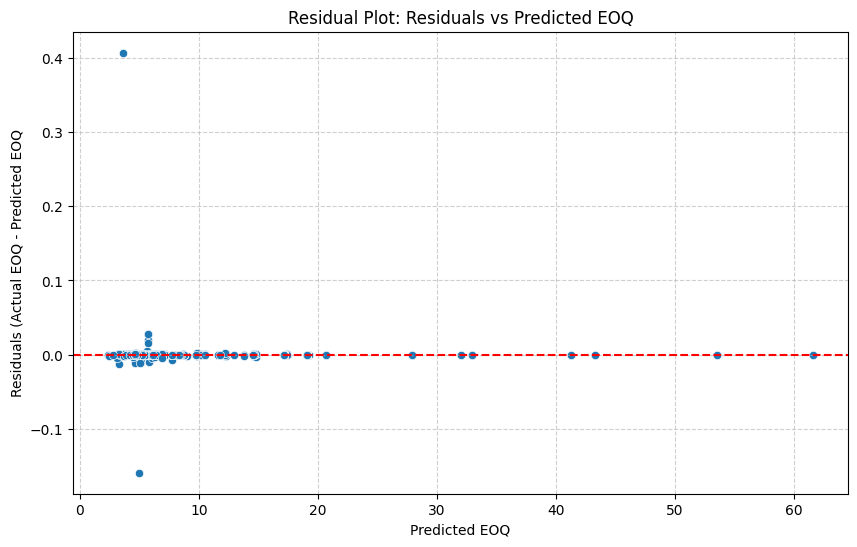

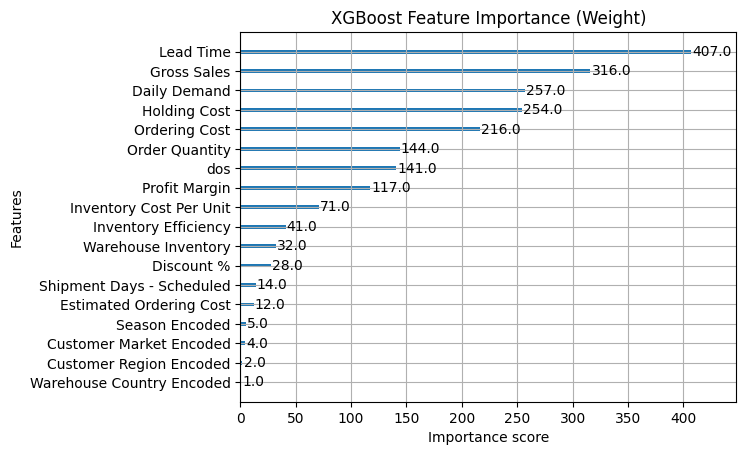


Feature Importances (Gain):
Daily Demand: 29874.9297
Lead Time: 8442.8838
Gross Sales: 358.3741
Holding Cost: 141.8976
Ordering Cost: 0.8131
Profit Margin: 0.3335
dos: 0.2573
Inventory Efficiency: 0.1517
Order Quantity: 0.0190
Discount %: 0.0174
Warehouse Inventory: 0.0014
Inventory Cost Per Unit: 0.0011
Season Encoded: 0.0007
Customer Market Encoded: 0.0001
Estimated Ordering Cost: 0.0001
Shipment Days - Scheduled: 0.0000
Customer Region Encoded: 0.0000
Warehouse Country Encoded: 0.0000


In [13]:
# --- 6. Plotting Residuals (After XGBoost) 
residuals = y_test - test_pred # Residuals on the log scale

plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted EOQ')
plt.ylabel('Residuals (Actual EOQ - Predicted EOQ')
plt.title('Residual Plot: Residuals vs Predicted EOQ')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 7. Feature Importance (XGBoost provides this directly) ---
# For plotting feature importance:
xgb.plot_importance(model_xgboost, importance_type='weight', max_num_features=26) 
plt.title('XGBoost Feature Importance (Weight)')
plt.show()

# get it as a dictionary
feature_importances = model_xgboost.get_booster().get_score(importance_type='gain')
print("\nFeature Importances (Gain):")
for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

## **Random Forest Regression**

In [14]:
rf = RandomForestRegressor()
model_rf = rf.fit(X_train, y_train)

In [15]:
y_pred = model_rf.predict(X)
val_pred = model_rf.predict(X_val)
test_pred = model_rf.predict(X_test)

mse = mean_squared_error(y_val, val_pred)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)
    
print(f"\nEvaluation on Random Forest Validation Set")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Evaluation on Random Forest Validation Set
R² Score: 1.0000
MAE: 0.0003
MSE: 0.0000
RMSE: 0.0070


In [16]:
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)
    
print(f"\nEvaluation on Random Forest Test Set")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Evaluation on Random Forest Test Set
R² Score: 1.0000
MAE: 0.0007
MSE: 0.0006
RMSE: 0.0236


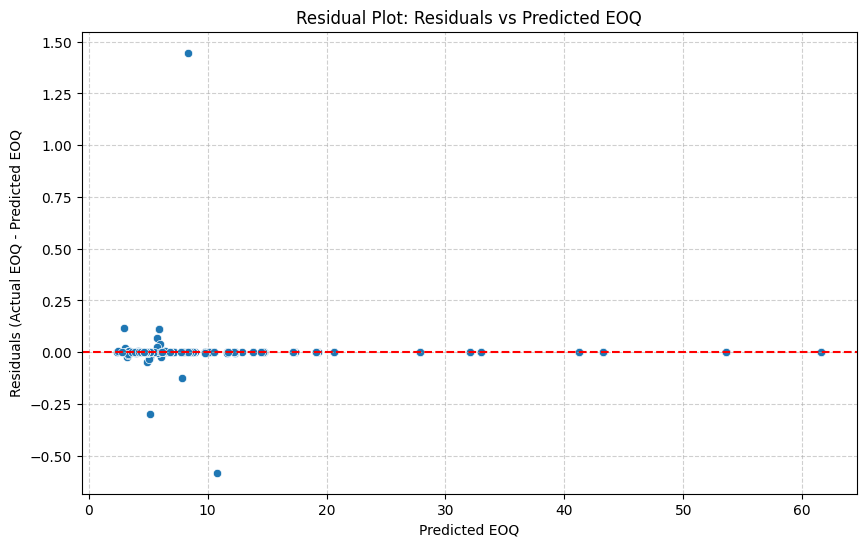

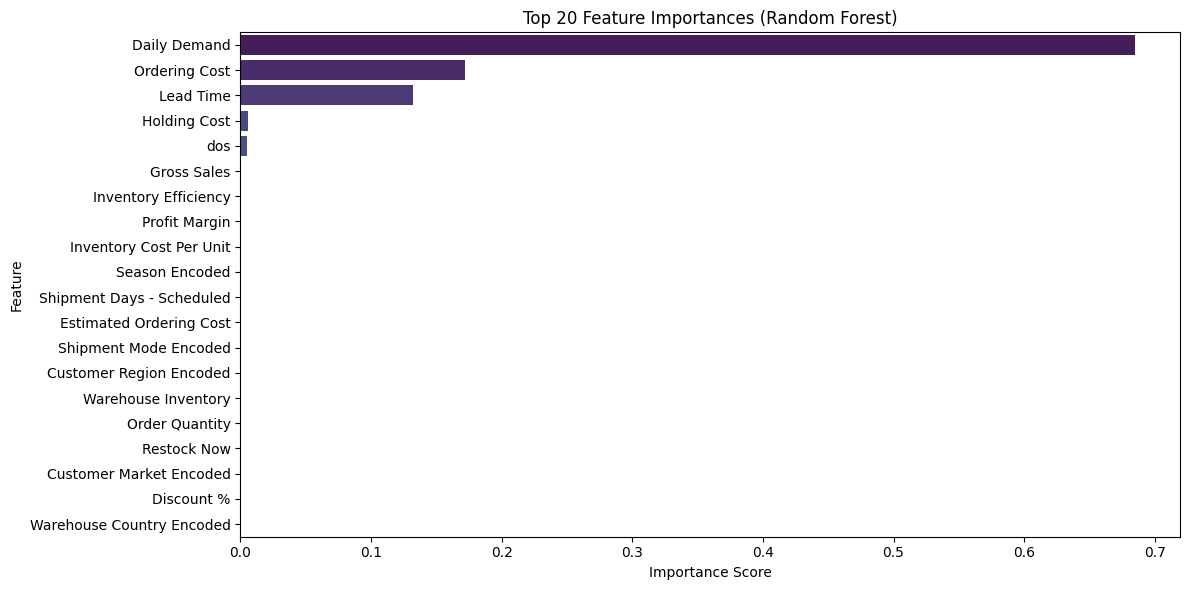


Feature Importances (Mean Decrease in Impurity):
Daily Demand: 0.6850
Ordering Cost: 0.1719
Lead Time: 0.1321
Holding Cost: 0.0058
dos: 0.0051
Gross Sales: 0.0000
Inventory Efficiency: 0.0000
Profit Margin: 0.0000
Inventory Cost Per Unit: 0.0000
Season Encoded: 0.0000
Shipment Days - Scheduled: 0.0000
Estimated Ordering Cost: 0.0000
Shipment Mode Encoded: 0.0000
Customer Region Encoded: 0.0000
Warehouse Inventory: 0.0000
Order Quantity: 0.0000
Restock Now: 0.0000
Customer Market Encoded: 0.0000
Discount %: 0.0000
Warehouse Country Encoded: 0.0000
Stockout: 0.0000
Holding Rate: 0.0000


In [17]:
# 6. Plotting Residuals 
residuals = y_test - test_pred 

plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted EOQ')
plt.ylabel('Residuals (Actual EOQ - Predicted EOQ')
plt.title('Residual Plot: Residuals vs Predicted EOQ')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 7. Feature Importance (XGBoost provides this directly) ---
# For plotting feature importance:
# Get feature importances as a DataFrame
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})

# Sort by importance
importances = importances.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=importances.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# get it as a dictionary
feature_names = X_train.columns
importances = model_rf.feature_importances_
feature_importance_dict = dict(zip(feature_names, importances))
print("\nFeature Importances (Mean Decrease in Impurity):")
for feature, importance in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")